# Analyzing Times Higher Education (THE) World University Rankings

Github link: https://github.com/Jleebs90/university_rankings/blob/master/Capstone.ipynb 

### Questions to Answer
* What factors are the best indicators of a university's ranking? 
* What other relationships exist between variables? 
* Can we predict rankings based on other variables? 

### Data Extraction
* Data Source:
    * Times Higher Education (THE) World University Rankings from 2011 - 2016
    * Uploaded from https://www.kaggle.com/tigranhovsepyan99/university-rankings/data 
 

* About the Data:
    * Dataset includes university rankings and THE scores, as well as non-scored variables such as university name, country, year, number of students, student:staff ratio, etc. 
    * Universities are ranked annually by their total score
    * The total score (0-100) is based on these scores:  
            * Teaching -  overall learning environment
            * Research - volume & reputation of research
            * Citations - influence of research
            * Income - industry knowledge transfer
            * International Outlook - staff, students & research  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.stats as stats
import seaborn as sns

# read data from dropbox file
df = pd.read_csv('https://www.dropbox.com/s/h1c5n4r41hlxzyy/timesData.csv?dl=1')

# view head, column names, summary of numeric columns
print(list(df)) 
df.head()



['world_rank', 'university_name', 'country', 'teaching', 'international', 'research', 'citations', 'income', 'total_score', 'num_students', 'student_staff_ratio', 'international_students', 'female_male_ratio', 'year']


,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,"15,596",7.8,22%,42 : 58,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,-,94.2,"7,929",8.4,27%,45 : 55,2011


### Data Cleaning
* Convert numeric columns from string to float
    * Convert ratios and percentages to decimals
    * Remove commas in numeric values
    * Apply float type when needed
    
    
* Create new column where ranking is a negative value
    * Since low rankings are good and high rankings are bad, visualizations can be confusing
    * We can use the negative ranking to make intuitive scatterplots 

In [2]:
# clean up columns with commas and percentages 
df['num_students'] = df['num_students'].str.replace(",","").astype(float)
df['international_students'] = df['international_students'].str.replace("%","").astype(float) / 100 

# convert columns to numeric type 
cols = ['world_rank', 'international', 'income', 'total_score', 'num_students', 'international_students']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Convert female:male ratio into numeric by partitioning the ratio then extracting the % females
df['female_male_ratio'] = df['female_male_ratio'].astype(str)
female = df['female_male_ratio'].str.partition(pat=':', expand=True)[0].apply(pd.to_numeric, errors='coerce')  
df['females'] = female/100

# create negative value for world ranking
df['world_rank_neg'] = 0 - df['world_rank']

df.describe() 

,world_rank,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,year,females,world_rank_neg
count,1112.000000,2603.000000,2594.000000,2603.000000,2603.000000,2385.000000,1201.000000,2544.000000,2544.000000,2536.000000,2603.000000,2367.000000,1112.000000
mean,98.201439,37.801498,52.007440,35.910257,60.921629,48.979874,59.846128,23873.758648,18.445283,0.154440,2014.075682,0.496840,-98.201439
std,58.097290,17.604218,22.103825,21.254805,23.073219,21.179938,12.803446,17675.946877,11.458698,0.105915,1.685733,0.108596,58.097290
min,1.000000,9.900000,7.100000,2.900000,1.200000,24.200000,41.400000,462.000000,0.600000,0.000000,2011.000000,0.010000,-200.000000
25%,48.000000,24.700000,33.425000,19.600000,45.500000,33.000000,50.300000,12637.750000,11.975000,0.080000,2013.000000,0.460000,-148.000000
50%,97.000000,33.900000,50.300000,30.500000,62.500000,41.000000,56.000000,20851.000000,16.100000,0.130000,2014.000000,0.520000,-97.000000
75%,148.000000,46.400000,69.000000,47.250000,79.050000,59.000000,66.200000,29991.000000,21.500000,0.210000,2016.000000,0.560000,-48.000000
max,200.000000,99.700000,100.000000,99.400000,100.000000,100.000000,96.100000,379231.000000,162.600000,0.820000,2016.000000,1.000000,-1.000000


### Data Visualization

#### Histograms: Visualizing distribution of score values 
* Citation scores are left-skewed (leaning to the right), while most score distributions are right-skewed.
    * Citations are counted objectively and therefore less critical? 
    
#### Scatter Plots: Visualizing relationships between scores and world rank
* All scores have a positive linear correlation with world rank

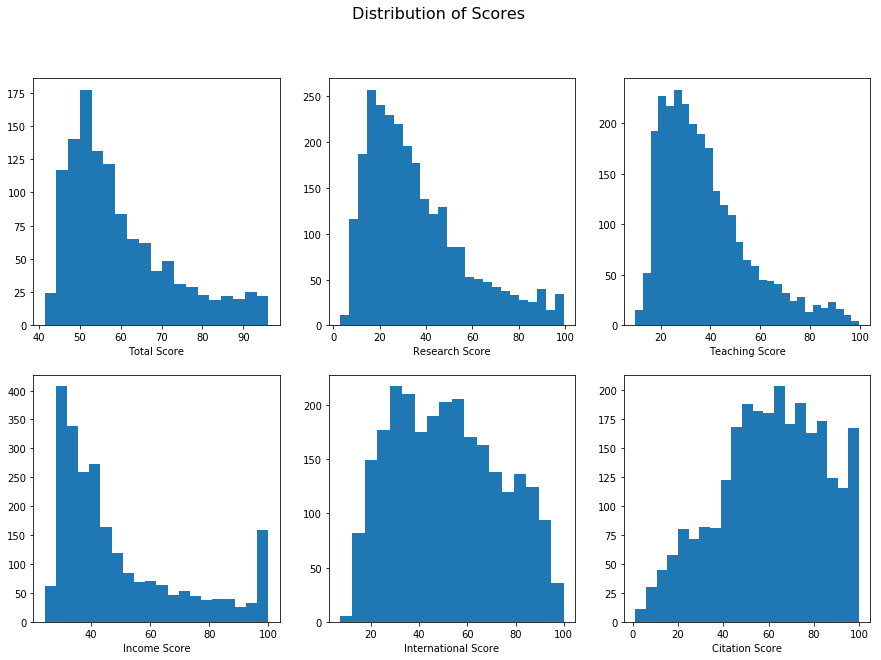

In [3]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,10)) 
fig.suptitle('Distribution of Scores', fontsize=16)

plt.subplot(2,3,1)
plt.xlabel('Total Score')
plt.hist(df['total_score'][~np.isnan(df['total_score'])], bins="auto")

plt.subplot(2,3,2)
plt.xlabel('Research Score')  
plt.hist(df['research'][~np.isnan(df['research'])], bins="auto")

plt.subplot(2,3,3)
plt.xlabel('Teaching Score')  
plt.hist(df['teaching'][~np.isnan(df['teaching'])],  bins="auto")


plt.subplot(2,3,4)
plt.xlabel('Income Score')
plt.hist(df['income'][~np.isnan(df['income'])], bins="auto")

plt.subplot(2,3,5)
plt.xlabel('International Score')  
plt.hist(df['international'][~np.isnan(df['international'])], bins="auto")

plt.subplot(2,3,6)
plt.xlabel('Citation Score')  
plt.hist(df['citations'][~np.isnan(df['citations'])],  bins="auto")
plt.show()


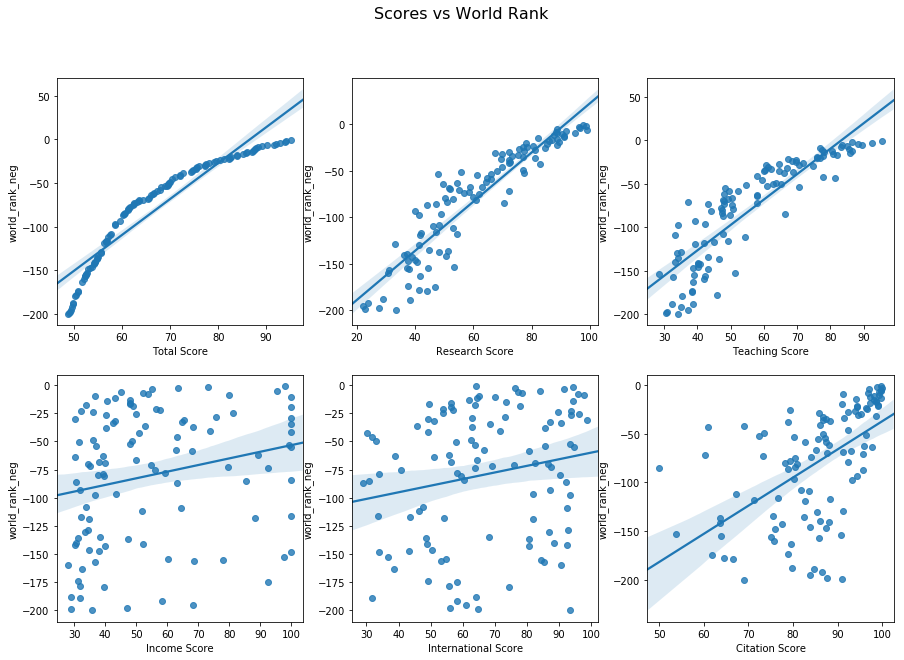

In [4]:
# using the negative ranking variable to make graphs more intuitive 
# isolate 2016 data to make the plots cleaner (no redundancy)

df16 = df.loc[df['year']==2016,:]
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,10)) 
fig.suptitle('Scores vs World Rank', fontsize=16)

plt.subplot(2,3,1)
sns.regplot(x='total_score', y="world_rank_neg", data=df16) 
plt.xlabel('Total Score')  

plt.subplot(2,3,2)
sns.regplot(x='research', y="world_rank_neg", data=df16) 
plt.xlabel('Research Score')  

plt.subplot(2,3,3)
sns.regplot(x='teaching', y="world_rank_neg", data=df16) 
plt.xlabel('Teaching Score')  

plt.subplot(2,3,4)
sns.regplot(x="income", y="world_rank_neg", data=df16) 
plt.xlabel('Income Score')   


plt.subplot(2,3,5)
sns.regplot(x="international", y="world_rank_neg", data=df16) 
plt.xlabel('International Score')   

plt.subplot(2,3,6)
sns.regplot(x="citations", y="world_rank_neg", data=df16) 
plt.xlabel('Citation Score')   

plt.show()

### Descriptive Analysis

* World rank is highly correlated with teaching and research scores (over .80) 
* Teaching and research scores are also highly correlated with each other (.91)
    * Are these metrics redundant or biased? 
* World rank is negatively correlated with student: staff ratio (-.26)
    * Makes sense - larger classrooms compromise quality
* The % of females is NEGATIVELY correlated with income score (-.35) 
   * Why do higher proportions of females bring income scores down? Harder for females to monetize and distribute their research? 

 

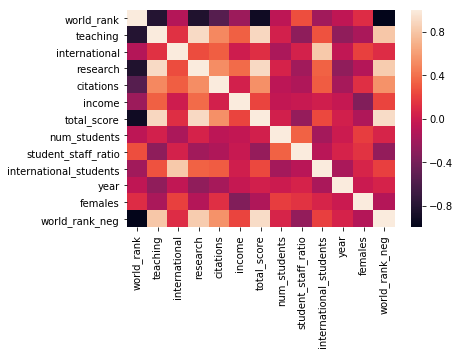

,world_rank,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,year,females,world_rank_neg
world_rank,1.000000,-0.809650,-0.113274,-0.832917,-0.549495,-0.225471,-0.919340,-0.063744,0.258907,-0.201389,-0.058574,0.114738,-1.000000
teaching,-0.809650,1.000000,0.137834,0.913120,0.503867,0.328457,0.894085,0.042844,-0.282630,0.278663,-0.278108,-0.156654,0.809650
international,-0.113274,0.137834,1.000000,0.251146,0.325030,0.011053,0.123829,-0.154742,0.053899,0.814798,-0.050160,0.206190,0.113274
research,-0.832917,0.913120,0.251146,1.000000,0.525264,0.381564,0.904166,0.059921,-0.198841,0.336260,-0.274451,-0.113632,0.832917
citations,-0.549495,0.503867,0.325030,0.525264,1.000000,0.045876,0.546015,-0.076886,-0.137737,0.314295,-0.173544,0.126031,0.549495
income,-0.225471,0.328457,0.011053,0.381564,0.045876,1.000000,0.226557,-0.044412,-0.020805,0.030033,-0.029956,-0.349623,0.225471
total_score,-0.919340,0.894085,0.123829,0.904166,0.546015,0.226557,1.000000,0.033979,-0.255692,0.234818,0.037239,-0.140555,0.919340
num_students,-0.063744,0.042844,-0.154742,0.059921,-0.076886,-0.044412,0.033979,1.000000,0.342824,-0.181870,0.003432,0.191069,0.063744
student_staff_ratio,0.258907,-0.282630,0.053899,-0.198841,-0.137737,-0.020805,-0.255692,0.342824,1.000000,-0.086417,0.060728,0.148303,-0.258907
international_students,-0.201389,0.278663,0.814798,0.336260,0.314295,0.030033,0.234818,-0.181870,-0.086417,1.000000,-0.158954,0.067836,0.201389


In [5]:
# correlation matrix
# note that low ranking is good, which is why world rank has negative correlations with other scores 
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()
corr

### Predicting University Rank from Scores

* How can we predict a university's ranking from its individual scores (not including total score)  
* Compare sklearn linear regression with random forest regression model 
    * Random forest is better fitting
    

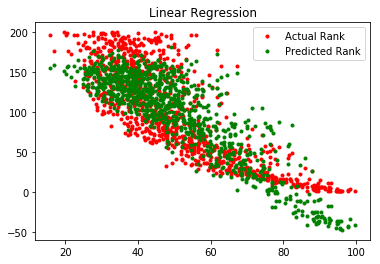

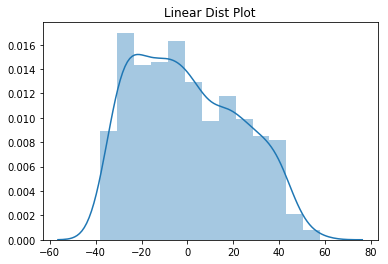

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


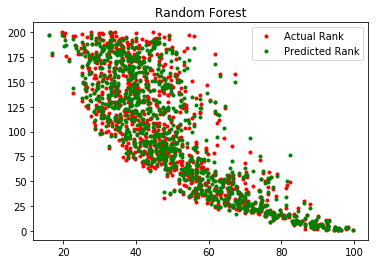

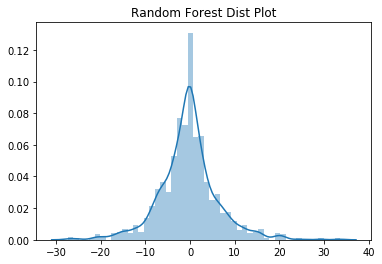

In [6]:
import sklearn
from patsy import dmatrices
from sklearn import ensemble
from sklearn import model_selection

%matplotlib inline

# Sklearn Linear regression 
from sklearn import linear_model
model = linear_model.LinearRegression(fit_intercept=False)
y,X = dmatrices('world_rank ~ teaching + research + international + income + citations', data=df)
model.fit(X, y)
yhat = model.predict(X)
plt.title("Linear Regression")
plt.plot(X[:,1], y, 'r.')
plt.plot(X[:,1], model.predict(X), 'g.')
plt.legend(['Actual Rank', 'Predicted Rank'])
plt.show() 

# view distribution of predictions vs actual 
sns.distplot(y - yhat)
plt.title("Linear Dist Plot")
plt.show()

# Random forest regression 
model = sklearn.ensemble.RandomForestRegressor()
y,X = dmatrices('world_rank ~ teaching + research + international + income + citations', data=df)
model.fit(X, y)
yhat = model.predict(X)
plt.title("Random Forest")
plt.plot(X[:,1], y, 'r.')
plt.plot(X[:,1], model.predict(X), 'g.')
plt.legend(['Actual Rank', 'Predicted Rank'])
plt.show() 


# view distribution of predictions vs actual 
sns.distplot(y.ravel() - yhat)
plt.title("Random Forest Dist Plot")
plt.show()

